In [43]:
import cv2
import numpy as np
import os 
from random import shuffle
from tqdm import tqdm

In [22]:
TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 100
LR = 1e-3
MODEL_NAME = 'Classified_Medicine-{}-{}.model'.format(LR,'6conv')

In [44]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'hydrox':
        return [1,0,0,0]
    elif word_label == 'lorazepam':
        return [0,1,0,0]
    elif word_label == 'ponstan':
        return [0,0,1,0]
    elif word_label == 'tylenol':
        return [0,0,0,1]

In [24]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img) , np.array(label)])
    shuffle(training_data)
    #np.save('train_data.npy', training_data)
    return training_data

In [25]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[-2]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img) , img_num])
    #np.save('test_data.npy', testing_data)
    return testing_data

In [26]:
train_data = create_train_data()
#train_data = np.load('train_data.npy')

100%|██████████| 1012/1012 [02:09<00:00,  8.10it/s]


In [27]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet , tensorboard_dir = 'log')


In [28]:
#model.load(MODEL_NAME)

In [29]:
train = train_data[:-200]
test = train_data[-200:]

In [30]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [35]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10,
          validation_set=({'input': test_x}, {'targets': test_y}),
          snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 519  | total loss: 0.36970 | time: 5.892s
| Adam | epoch: 040 | loss: 0.36970 - acc: 0.9510 -- iter: 768/812
Training Step: 520  | total loss: 0.33586 | time: 7.409s
| Adam | epoch: 040 | loss: 0.33586 - acc: 0.9559 | val_loss: 0.01506 - val_acc: 1.0000 -- iter: 812/812
--
INFO:tensorflow:/Users/patiroop/Desktop/kai/ProjectAI/Classified_Medicine-0.001-6conv.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 200/200 [00:25<00:00,  7.08it/s]


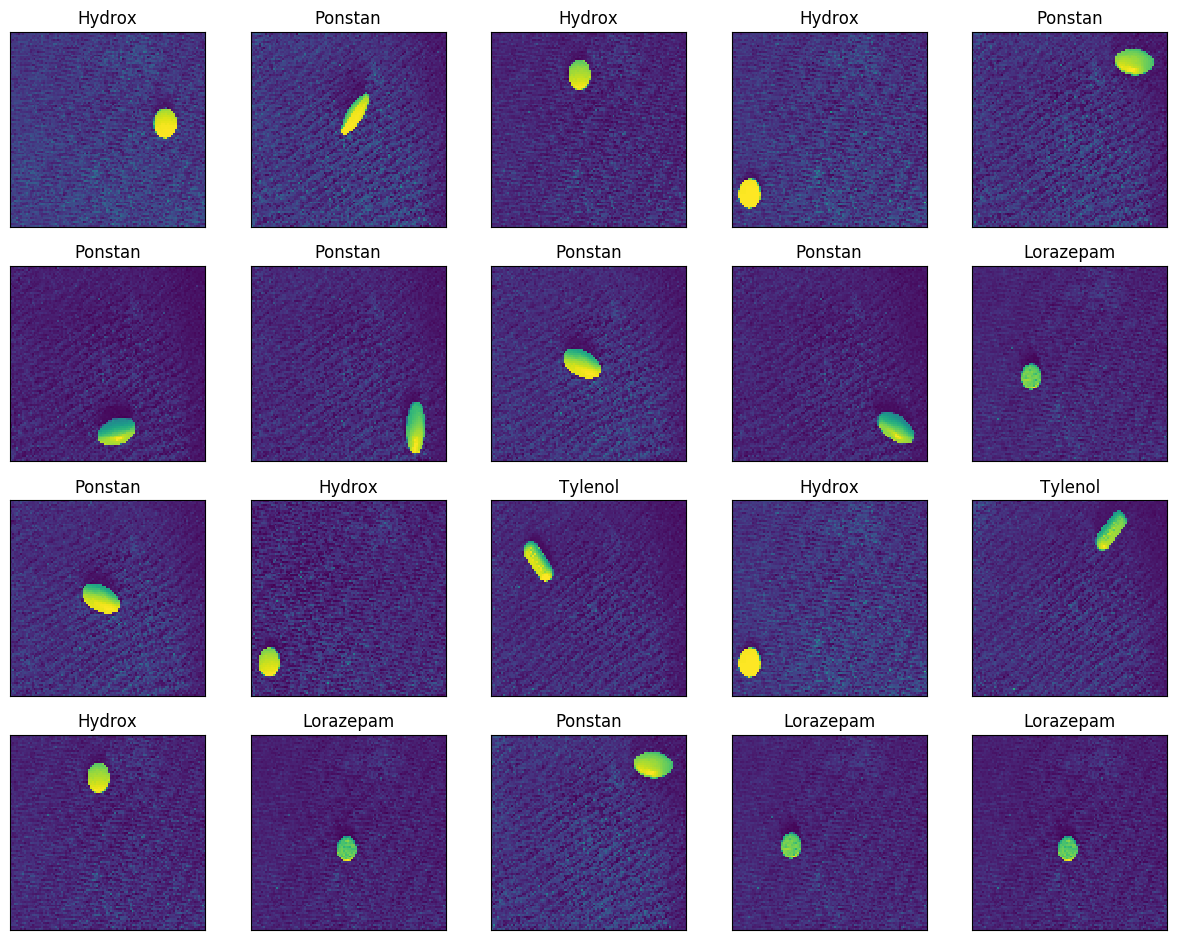

In [42]:
import matplotlib.pyplot as plt

test_data = process_test_data()
#test_data = np.load('test_data.npy')

fig = plt.figure(figsize=(15,15) , dpi=100)

#     if word_label == 'hydrox':
#         return [1,0,0,0]
#     elif word_label == 'lorazepam':
#         return [0,1,0,0]
#     elif word_label == 'ponstan':
#         return [0,0,1,0]
#     elif word_label == 'tylenol':
#         return [0,0,0,1]

for num, data in enumerate(test_data[:20]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    
    model_out = model.predict([data])[0]

    if np.argmax(model_out) == 0:
        str_label = 'Hydrox'
    elif np.argmax(model_out) == 1:
        str_label = 'Lorazepam'
    elif np.argmax(model_out) == 2:
        str_label = 'Ponstan'
    elif np.argmax(model_out) == 3:
        str_label = 'Tylenol'
        
    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()